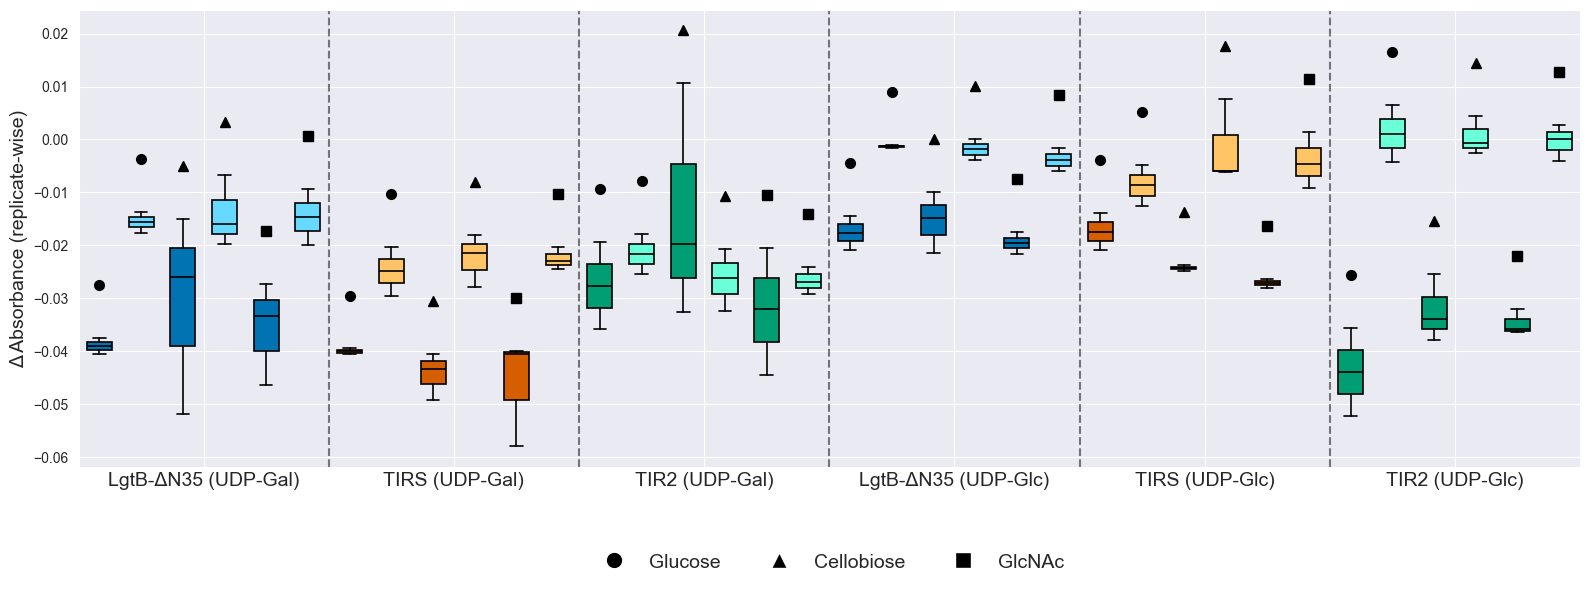

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Setup ---
file_path = r'C:\Users\[...]\X.xlsx'
palette = sns.color_palette("colorblind", 10)
enzyme_color_map = {
    "LgtB-ΔN35": palette[0],
    "TIRS": palette[3],
    "TIR2": palette[2]
}

blank_lighter = lambda c: tuple(min(1, x + 0.4) for x in c)

enzyme_rows_gal = {
    "LgtB-ΔN35": (1, 13),
    "TIRS": (15, 27),
    "TIR2": (29, 41)
}
enzyme_rows_glc = {
    "LgtB-ΔN35": (1, 13),
    "TIRS": (15, 27),
    "TIR2": (29, 41)
}

substrate_icons = {
    "Glucose": "o",
    "Cellobiose": "^",
    "GlcNAc": "s"
}

def extract_data(sheet_names, enzyme_rows):
    xls = pd.ExcelFile(file_path)
    data = {}
    for sheet_name in sheet_names:
        df = xls.parse(sheet_name, header=None)
        sheet_data = {}
        for enzyme, (start, end) in enzyme_rows.items():
            enzyme_section = df.iloc[start:end]
            time_values = enzyme_section.iloc[1, 1:].astype(float).values
            temp_values = enzyme_section.iloc[2, 1:].astype(float).values
            temp_mean = np.mean(temp_values)

            substrates = {}
            i = 4
            while i < len(enzyme_section):
                if pd.notna(enzyme_section.iloc[i, 0]):
                    substrate = enzyme_section.iloc[i, 0]
                    values = []
                    while i < len(enzyme_section) and enzyme_section.iloc[i, 0] == substrate:
                        values.append(enzyme_section.iloc[i, 1:].astype(float).values)
                        i += 1
                    substrates[substrate] = np.asarray(values)
                else:
                    i += 1

            sheet_data[enzyme] = {"time": time_values, "temp": temp_mean, "substrates": substrates}
        data[sheet_name] = sheet_data
    return data

# --- Load both UDP-Gal and UDP-Glc data ---
data_gal = extract_data(["Activity", "Blanks"], enzyme_rows_gal)
data_glc = extract_data(["Glc Activity", "Glc Blanks"], enzyme_rows_glc)

# --- Create boxplot ---
fig, ax = plt.subplots(figsize=(16, 6))

delta_data = []
box_colors = []
substrate_shapes = []
enzyme_boundaries = []
group_labels = []
positions = []

current_pos = 0

def process_data(data, label_prefix, label_display):
    global current_pos
    for enzyme in enzyme_rows_gal.keys():
        enzyme_color = enzyme_color_map[enzyme]
        enzyme_start = current_pos
        for substrate in ["Glucose", "Cellobiose", "GlcNAc"]:
            activity = data[label_prefix + "Activity"][enzyme]["substrates"][substrate]
            blanks = data[label_prefix + "Blanks"][enzyme]["substrates"][substrate]

            activity_deltas = activity[:, -1] - activity[:, 0]
            blank_deltas = blanks[:, -1] - blanks[:, 0]

            delta_data.append(activity_deltas)
            positions.append(current_pos)
            box_colors.append(enzyme_color)
            substrate_shapes.append(substrate_icons[substrate])
            group_labels.append("")
            current_pos += 1

            delta_data.append(blank_deltas)
            positions.append(current_pos)
            box_colors.append(blank_lighter(enzyme_color))
            substrate_shapes.append(substrate_icons[substrate])
            group_labels.append("")
            current_pos += 1
        enzyme_boundaries.append((f"{enzyme} ({label_display})", enzyme_start, current_pos - 1))

# Add UDP-Gal
process_data(data_gal, "", "UDP-Gal")
# Add UDP-Glc
process_data(data_glc, "Glc ", "UDP-Glc")

# Draw the colored boxplot
box = ax.boxplot(delta_data, positions=positions, patch_artist=True, widths=0.6)

for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.2)

for element in ['whiskers', 'caps', 'medians']:
    for line in box[element]:
        line.set_color('black')
        line.set_linewidth(1.2)

# Add icons above each box
for idx, shape in enumerate(substrate_shapes):
    ymax = np.max(delta_data[idx])
    ax.plot(positions[idx], ymax + 0.01, shape, color='black', markersize=7)

# Set enzyme group labels
xtick_positions = []
xtick_labels = []

for enzyme_name, start, end in enzyme_boundaries:
    mid = (start + end) / 2
    xtick_positions.append(mid)
    xtick_labels.append(enzyme_name)

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, fontsize=14)
ax.tick_params(axis='x', length=0)

# Dashed lines to separate groups
group_boundaries = [end + 1 for _, _, end in enzyme_boundaries[:-1]]
for boundary in group_boundaries:
    ax.axvline(x=boundary - 0.5, color='black', linestyle='--', alpha=0.5)

# Axis formatting
ax.set_ylabel("Δ Absorbance (replicate-wise)", fontsize=14)
ax.set_xlim(-0.5, current_pos - 0.5)
ax.set_xlabel("")
ax.set_title("")

# Legend for shapes under plot
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Glucose', markerfacecolor='black', markersize=12),
    plt.Line2D([0], [0], marker='^', color='w', label='Cellobiose', markerfacecolor='black', markersize=12),
    plt.Line2D([0], [0], marker='s', color='w', label='GlcNAc', markerfacecolor='black', markersize=12)
]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False, fontsize=14)

plt.tight_layout()
plt.show()




L.ΔN35, UDP-Gal - Glucose (UDP-Gal): p-value = 1.0882e-02, Cohen's d = -9.39
L.ΔN35, UDP-Gal - Cellobiose (UDP-Gal): p-value = 1.5975e-01, Cohen's d = -1.18
L.ΔN35, UDP-Gal - GlcNAc (UDP-Gal): p-value = 1.3535e-01, Cohen's d = -2.68
TIRS, UDP-Gal - Glucose (UDP-Gal): p-value = 1.6630e-01, Cohen's d = -3.27
TIRS, UDP-Gal - Cellobiose (UDP-Gal): p-value = 2.5904e-02, Cohen's d = -4.63
TIRS, UDP-Gal - GlcNAc (UDP-Gal): p-value = 5.7888e-02, Cohen's d = -3.17
TIR2, UDP-Gal - Glucose (UDP-Gal): p-value = 4.0373e-01, Cohen's d = -0.67
TIR2, UDP-Gal - Cellobiose (UDP-Gal): p-value = 3.2371e-01, Cohen's d = 0.77
TIR2, UDP-Gal - GlcNAc (UDP-Gal): p-value = 5.7292e-01, Cohen's d = -0.65
L.ΔN35, UDP-Glc - Glucose (UDP-Glc): p-value = 1.3611e-01, Cohen's d = -5.01
L.ΔN35, UDP-Glc - Cellobiose (UDP-Glc): p-value = 8.0497e-02, Cohen's d = -3.13
L.ΔN35, UDP-Glc - GlcNAc (UDP-Glc): p-value = 6.4721e-03, Cohen's d = -7.40
TIRS, UDP-Glc - Glucose (UDP-Glc): p-value = 4.4444e-01, Cohen's d = -1.68
TIRS, 

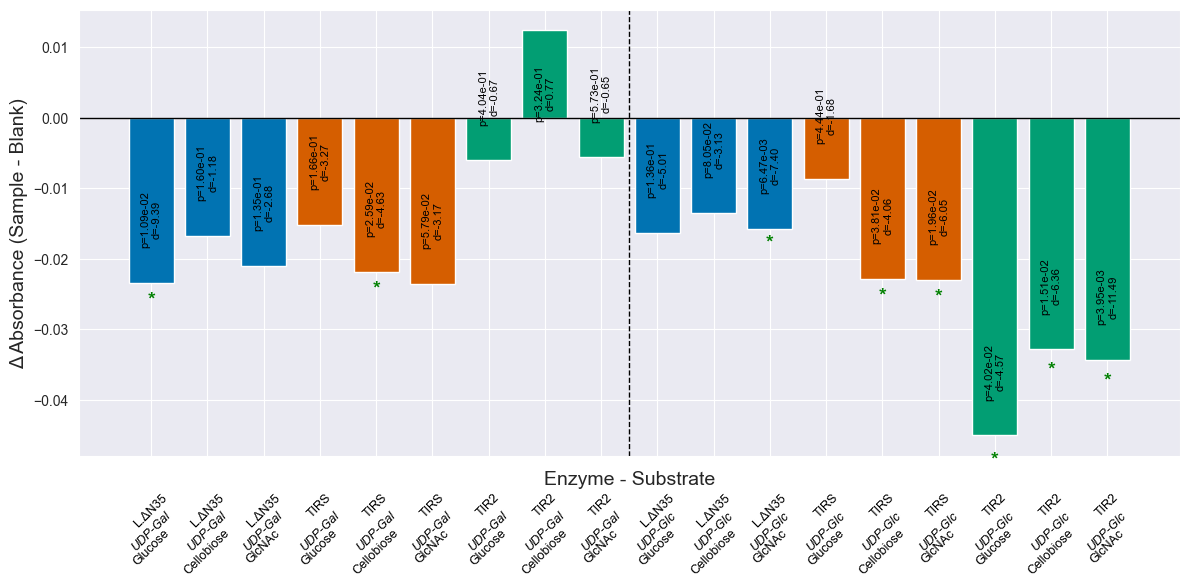

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel
from scipy.interpolate import interp1d

# Load the Excel file
file_path = r'C:\Users\[...]\X.xlsx'
xls = pd.ExcelFile(file_path)

# Use Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)

# Define enzyme row indices for both experiments
enzyme_rows_gal = {
    "L.ΔN35, UDP-Gal": (1, 13),
    "TIRS, UDP-Gal": (15, 27),
    "TIR2, UDP-Gal": (29, 41)
}
enzyme_rows_glc = {
    "L.ΔN35, UDP-Glc": (1, 13),
    "TIRS, UDP-Glc": (15, 27),
    "TIR2, UDP-Glc": (29, 41)
}

# Sheet names mapping
sheet_info = {
    "UDP-Gal": ("Activity", "Blanks", enzyme_rows_gal),
    "UDP-Glc": ("Glc Activity", "Glc Blanks", enzyme_rows_glc)
}

# Load data
all_data = {}
for label, (activity_sheet, blank_sheet, enzyme_rows) in sheet_info.items():
    data = {}
    for sheet_name in [activity_sheet, blank_sheet]:
        df = xls.parse(sheet_name, header=None)
        sheet_data = {}
        for enzyme, (start, end) in enzyme_rows.items():
            enzyme_section = df.iloc[start:end]
            time_values = enzyme_section.iloc[1, 1:].astype(float).values
            temp_values = enzyme_section.iloc[2, 1:].astype(float).values
            temp_mean = np.mean(temp_values)

            substrates = {}
            i = 4
            while i < len(enzyme_section):
                if pd.notna(enzyme_section.iloc[i, 0]):
                    substrate = enzyme_section.iloc[i, 0]
                    values = []
                    while i < len(enzyme_section) and enzyme_section.iloc[i, 0] == substrate:
                        values.append(enzyme_section.iloc[i, 1:].astype(float).values)
                        i += 1
                    substrates[substrate] = np.asarray(values)
                else:
                    i += 1

            sheet_data[enzyme] = {"time": time_values, "temp": temp_mean, "substrates": substrates}
        data[sheet_name] = sheet_data
    all_data[label] = data

# Define enzyme colors (same across both experiments)
enzyme_colors = {
    "L.ΔN35": palette[0],
    "TIRS": palette[3],
    "TIR2": palette[2]
}

# Prepare visualization
plt.figure(figsize=(12, 6))
x_labels = []
bar_values = []
bar_colors = []
annotations = []
group_split_index = 0  # to determine where to draw the separating line

# Iterate over both experiments
for idx, label in enumerate(sheet_info):
    activity_data = all_data[label][sheet_info[label][0]]
    blank_data = all_data[label][sheet_info[label][1]]

    for enzyme in sheet_info[label][2].keys():
        base_name = enzyme.split(",")[0]
        for substrate in ["Glucose", "Cellobiose", "GlcNAc"]:
            activity = activity_data[enzyme]["substrates"][substrate]
            blanks = blank_data[enzyme]["substrates"][substrate]

            # Compute replicate-wise deltas
            activity_deltas = activity[:, -1] - activity[:, 0]
            blank_deltas = blanks[:, -1] - blanks[:, 0]

            # Perform paired t-test
            p_value = ttest_rel(activity_deltas, blank_deltas).pvalue

            # Compute Cohen’s d from replicate deltas
            mean_diff = np.mean(activity_deltas - blank_deltas)
            pooled_std = np.sqrt((np.std(activity_deltas, ddof=1)**2 + np.std(blank_deltas, ddof=1)**2) / 2)
            effect_size = mean_diff / pooled_std if pooled_std > 0 else np.nan  # avoid div by zero

            # Print result for traceability
            print(f"{enzyme} - {substrate} ({label}): p-value = {p_value:.4e}, Cohen's d = {effect_size:.2f}")

            delta_abs = mean_diff
            color = enzyme_colors.get(base_name, "gray")

            # Append for plotting
            bar_values.append(delta_abs)
            bar_colors.append(color)
            x_labels.append((enzyme, substrate, label))
            annotations.append((p_value, effect_size))

    if idx == 0:
        group_split_index = len(bar_values)

# Plotting
x = np.arange(len(bar_values))
plt.bar(x, bar_values, color=bar_colors)

# Draw separating line between UDP-Gal and UDP-Glc
plt.axvline(x=group_split_index - 0.5, color='black', linestyle='--', linewidth=1)

# Annotations with significance indication (rotated vertically inside bars)
for i, ((enzyme, substrate, label), (p, d)) in enumerate(zip(x_labels, annotations)):
    y_val = bar_values[i]
    gap = 0.05 * max(abs(y_val), 0.1)
    y_pos = y_val - gap if y_val > 0 else y_val + gap
    align = 'top' if y_val > 0 else 'bottom'
    annotation_text = f"p={p:.2e}\nd={d:.2f}"

    # Text inside the bars
    plt.text(
        x[i], y_pos, annotation_text,
        ha='center', va=align, fontsize=8, color='black',
        rotation=90,
    )

    # Star for significance
    if p < 0.05:
        star_y = y_val + (0.05 * abs(y_val)) if y_val > 0 else y_val - (0.05 * abs(y_val))
        plt.text(
            x[i], star_y, "*",
            ha='center', va='bottom' if y_val > 0 else 'top',
            fontsize=14, fontweight='bold', color='green'
        )

# Custom X-axis labels with italic UDP part
ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels([""] * len(x))

for i, (enzyme, substrate, label) in enumerate(x_labels):
    base_name = enzyme.split(",")[0]
    sugar = "UDP-Gal" if "Gal" in enzyme else "UDP-Glc"
    enzyme_part = enzyme.replace(f", {sugar}", "")

    y_offset = -0.08
    ax.text(x[i], y_offset, enzyme_part, ha='center', va='top', rotation=45, fontsize=9, color='black', transform=ax.get_xaxis_transform())
    ax.text(x[i], y_offset - 0.04, sugar, ha='center', va='top', rotation=45, fontsize=9, style='italic', color='black', transform=ax.get_xaxis_transform())
    ax.text(x[i], y_offset - 0.08, substrate, ha='center', va='top', rotation=45, fontsize=9, color='black', transform=ax.get_xaxis_transform())

plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Enzyme - Substrate", fontsize=14)
plt.ylabel("Δ Absorbance (Sample - Blank)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
